This is my solution for the skill test

In [2]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np

os.sys.path.append('./..')
from utils.loadgenius import DataLoader
from utils.pretty import pprint, plot_missing_values, plot_value_counts
from utils.consignee_extract import parse_string_to_dict
from utils.country_name_detect import get_model

# Pointing the loader to the data loading instruction
dl = DataLoader('./../catalog.yml')

pprint(f"""Available dataset: \\
       {dl.list_datasets()}""")

Available dataset: \
       ['importer_normalized_data', 'main', 'ports']

In [3]:
%%time
# Loading in datasets
ports = dl.load('ports').drop('Unnamed: 0', axis=1)
main = dl.load('main').drop('Unnamed: 0', axis=1)
importer = dl.load('importer_normalized_data').drop('Unnamed: 0', axis=1)

CPU times: user 23.5 s, sys: 1.15 s, total: 24.7 s
Wall time: 24.8 s


# Preprocess

# `importer_normalized_data.csv`: duplicated raw names

In [4]:
pprint("Some raw names are duplicated")
report = importer["importer_raw_name"].value_counts()
display(report[report > 1])

Some raw names are duplicated

importer_raw_name
MASONITE LAWRENCEVILLE DFS         2
ANATOLIA TILE & STONE, INC. 202    2
MASONITE LAWRENCEVILLE             2
SINTEX MINERALS                    2
METSO MINERALS WAUKESHA            2
Name: count, dtype: int64

Example:

In [5]:
importer.query('importer_raw_name=="MASONITE LAWRENCEVILLE DFS"')

importer_rank           importer_raw_name       importer_deduped_name
21480           3354  MASONITE LAWRENCEVILLE DFS               MASONITE CORP
46134           9981  MASONITE LAWRENCEVILLE DFS  MASONITE LAWRENCEVILLE DFS

**Resolve:** Keep the row with highest rank 

In [6]:
importer = importer.sort_values('importer_rank').drop_duplicates(subset=['importer_raw_name'], keep='first')


## `ports.csv`: remove duplicates

In [7]:
print("ports: Rows before", ports.shape[0])
ports = (ports
         .drop_duplicates()
         .reset_index(drop=True)
        )
print("ports: Rows after de-duplicates", ports.shape[0])

ports: Rows before 10927
ports: Rows after de-duplicates 5726


## `main.csv`: extract important fields & drop duplicates

In [8]:
%%time
import multiprocessing as mp

original_columns = main.columns

with mp.Pool() as pool:
    result = pool.map(parse_string_to_dict, main['consignee'])
    
main['extracted'] = result
del(result)

CPU times: user 38.4 s, sys: 7.33 s, total: 45.7 s
Wall time: 1min 19s


In [9]:
# Double check if the extraction fails on any record
if any(main['extracted'].isna()):
    pprint("Extraction failed somewhere")
else:
    pprint("Extraction success")
    

Extraction success

Extract further on `cleaned_address_breakdown`

In [10]:
%%time
# Extract information in cleaned address
address_bits = ['address_number',
                 'country_name',
                 'place_name',
                 'state_name',
                 'street_name',
                 'street_name_post_type',
                 'street_name_pre_directional',
                 'street_name_pre_type',
                 'zip_code']

for bit in address_bits:
    main[bit] = main['extracted'].apply(lambda x: x['cleaned_address_breakdown'].get(bit, '')).replace('', pd.NA)
    print(f"Processing {bit}", end='\r')
    
main['id'] = main['extracted'].apply(lambda x: x['id'])
main['importer_raw_name'] = main['extracted'].apply(lambda x: x['name']).str.upper()

CPU times: user 22.4 s, sys: 307 ms, total: 22.7 s
Wall time: 22.8 s


Since we only care about names that exists in importer list:

In [11]:
importer['importer_raw_name'] = importer['importer_raw_name'].str.upper()
main = main.merge(importer, how='inner', on='importer_raw_name')

We want to check the number of nulls in each column:

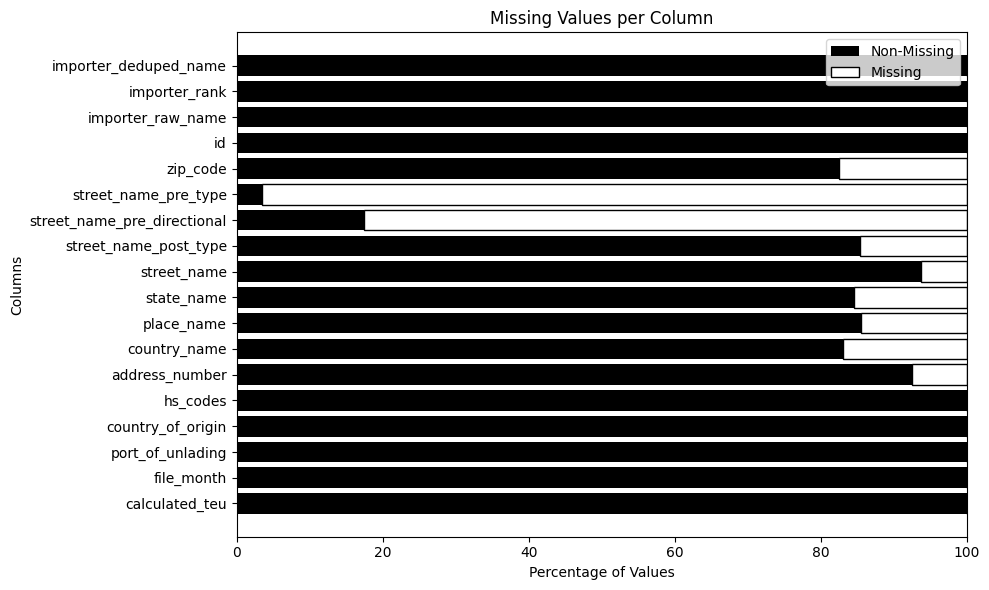

In [12]:
plot_missing_values(main.drop(["consignee", "extracted"],
                              axis=1),
                    as_percentage=True
                   )

### Observation 1: missing counts
`street_name_pre_type` and `street_name_pre_directional` have very high missing counts (approx 96% and 80% respectively)

### Observation 3: Imperfection of the cleaning method:

`cleaned_address_breakdown` seems to be a result by another extraction procedure.
This extraction is not perfect, as shown  in the graph of top 10 countries by frequencies in `main.csv`: sometimes it excludes STATES from UNITED STATES, yielding UNITED (which is a mistake)

In [ ]:
fig, ax = plt.subplots()
main['country_name'].value_counts().head(20)[::-1].plot.barh(log=True, ax=ax);
ax.set_title("Most popular consignee countries in main.csv. Log scale")
plt.show()

In [ ]:
pprint("An example where UNITED STATES became UNITED after *cleaned*:")
pprint(main[main['country_name']=='UNITED']['consignee'].iloc[9])

In addition, sometimes the state name or another territory name gets in the `country_name`: NY in NY USA for instance.

Finally, synonyms were not handled at all: UNITED STATES, USA, US, USA US are the same thing.

Imperfection of the extraction on the country name level is a strong reason to assume the same happening in lower levels.

**How to fix that?** Use a better extraction method, such as Named Entity Recognition. For instance:

#### Demo Named-Entity-Recognition

In [ ]:
from spacy import displacy
    
nlp = get_model() # Retrieve an example NER model for country name detection

# Get some example consignee strings
samples_others = list(main[main['country_name'].str.lower().str.contains('serbia|taiwan') == True]['consignee'])[:2]
samples_us = list(main[main['country_name'].str.lower().str.contains('usa|united state| us') == True]['consignee'])[:1]

pprint("Showing an alternative way to extract country name:")
for example in samples_others + samples_us:
    displacy.render(
        nlp(example),
        style='ent')
    print("="*20)

In the example above, my model is able to detect both US and UNITED STATES as the synonyms for USA.

Since developing such as model requires gathering  more country names and synonyms, I only show an example for a small number of countries as above.

### Observation 2: duplicated rows

Many rows are exactly the same. **Possible reasons:**
- someone made a join with another duplicated dataframe ealier, resulting in duplicates in `main.csv`
- there's a missing column, which can be a key by itself or part of a composite key.

In [13]:
pd.set_option('display.max_colwidth', None)
pprint("Example of duplicated rows")
(
    main
    .query('id=="857a923157f99f7c13920a7e563ae9b2" & hs_codes=="HS CODE 8708 0000" & file_month==10')
    .sort_values('consignee')
    .head(3)[original_columns]
)

Example of duplicated rows

consignee  \
1189926  {name=DETROIT DIESEL PARTS DISTRIBUTION, address=CENTER 515 11TH STREET SE CANTON, OH 44707, cleaned_address=515 11TH STREET, CANTON, OH 44707, USA, cleaned_address_breakdown={address_number=515, country_name=USA, place_name=CANTON, state_name=OH, street_name=11TH, street_name_post_type=STREET, street_name_pre_directional=, street_name_pre_type=, zip_code=44707}, contact_name=, comm_number_qualifier=, comm_number=, id=857a923157f99f7c13920a7e563ae9b2}   
1199815  {name=DETROIT DIESEL PARTS DISTRIBUTION, address=CENTER 515 11TH STREET SE CANTON, OH 44707, cleaned_address=515 11TH STREET, CANTON, OH 44707, USA, cleaned_address_breakdown={address_number=515, country_name=USA, place_name=CANTON, state_name=OH, street_name=11TH, street_name_post_type=STREET, street_name_pre_directional=, street_name_pre_type=, zip_code=44707}, contact_name=, comm_number_qualifier=, comm_number=, id=857a923157f99f7c13920a7e563ae9b2}   
1199816  {name=DETROIT DIESEL PARTS DISTRIBUTION, address=CENTER 515 11TH STREET SE CANTON, OH 44707, cleaned_address=515 11TH STREET, CANTON, OH 44707, USA, cleaned_address_breakdown={address_number=515, country_name=USA, place_name=CANTON, state_name=OH, street_name=11TH, street_name_post_type=STREET, street_name_pre_directional=, street_name_pre_type=, zip_code=44707}, contact_name=, comm_number_qualifier=, comm_number=, id=857a923157f99f7c13920a7e563ae9b2}   

         calculated_teu  file_month  port_of_unlading country_of_origin  \
1189926             2.0          10              1401            FRANCE   
1199815             2.0          10              1401            FRANCE   
1199816             2.0          10              1401            FRANCE   

                  hs_codes  
1189926  HS CODE 8708 0000  
1199815  HS CODE 8708 0000  
1199816  HS CODE 8708 0000

**Assuming this duplication is an error** (likely caused by join with duplicated data), I drop the duplicates:

In [14]:
before = main.shape[0]
pprint(f"`main.csv`: Number of rows before = {before}")
main = main.drop_duplicates(subset=original_columns)
pprint(f"`main.csv`: Number of rows after drop_duplicates = {main.shape[0]}")
pprint(f"Drop rate = {round(100*(1- main.shape[0]/before))}%")

`main.csv`: Number of rows before = 1385308

`main.csv`: Number of rows after drop_duplicates = 531578

Drop rate = 62%

### HS codes mapping

In this subsection, I convert the first 6 digits in HS codes to their description.

The first 6 digits tell the Subheadings of the product according to my [source](https://findrulesoforigin.org/en/glossary?uid=hs&returnto=faqscenter)

Implementation details:

- I used an opensource database [here](https://github.com/datasets/harmonized-system/tree/master) to lookup the hs codes
- To speed-up, I search for **unique hs codes** before mapping, rather than mapping straight away

In [15]:
hs_table = pd.read_csv('https://raw.githubusercontent.com/datasets/harmonized-system/master/data/harmonized-system.csv', dtype='str')

main['hs_codes_shorten'] = main['hs_codes'].str.replace(r'(\D)', '', regex=True).apply(lambda x: x[:6])

def query_hs_codes_desc(code, table):
    result = table.query("hscode==@code")['description']
    if result.shape[0] == 0:
        return None
    else:
        return list(result)[0]

hs_mapping = main[['hs_codes_shorten']].drop_duplicates().reset_index(drop=True)
hs_mapping['desc'] = hs_mapping['hs_codes_shorten'].apply(
    lambda x: query_hs_codes_desc(x, hs_table)
)

hs_mapping = hs_mapping.set_index('hs_codes_shorten')['desc']
hs_mapping = hs_mapping.to_dict()
main['hs_codes_desc'] = main['hs_codes_shorten'].apply(lambda x: hs_mapping[x])

In [16]:
plot_missing_values(main[['hs_codes', "hs_codes_desc"]], as_percentage=True)

It shows that while every row has hs codes, about 11% don't have a know description according to my database (version 2022).

It is possible that some data uses 2021 versions: HS CODE 9401 3000 for instance.

Within the timeframe of this skill test, I simply ignore those data for now.

In [17]:
pprint("Showing some unknown hs codes:")
main[main['hs_codes_desc'].isna()][['hs_codes']].drop_duplicates().sort_values('hs_codes')

Showing some unknown hs codes:

hs_codes
91471    HS CODE 0000 0000
872081   HS CODE 0000 0015
872082   HS CODE 0000 0018
547031   HS CODE 0000 0124
1176836  HS CODE 0000 0665
...                    ...
816787   HS CODE 9990 6300
165913   HS CODE 9990 7700
491994   HS CODE 9990 8700
344132   HS CODE 9990 8704
898050   HS CODE 9999 0000

[8692 rows x 1 columns]

# Analytics plan

To find out which company is worth investing, we care about the following things:
- What they import
- How frequent they import that product and how much, compared to other importer
- How much (in teu) they import that product, compared to the norm
- How diverse are their imports: Diversing but small company might be a redflag. A focused portfolio is always a good sign.
- Do they diversify their sources? How many ports of unloading? Higher can be an implication of scaled logistics activity. 
- ... PCA then clustering. Check if importers with higher rank cluster

In [68]:
def generate_sample_history(query=None):
    if query is None:
        sample_importer = list(main['id'].drop_duplicates().sample(1))[0]
    else:
        sample_importer = list(main.query(query)['id'].drop_duplicates().sample(1))[0]
    print(sample_importer)
    sample_history = main[main["id"]==sample_importer]
    return (
        sample_history[['file_month', 'hs_codes', 'calculated_teu',
                        'country_of_origin', 'port_of_unlading', 
                        'importer_deduped_name', 'importer_rank']].sort_values(
        ['file_month', 'hs_codes']
        )
        )


In [164]:
importer[['importer_rank', 'importer_deduped_name']].drop_duplicates().head(10)

importer_rank            importer_deduped_name
0                1         DOLE FRESH FRUIT COMPANY
51               2  SAMSUNG ELECTRONICS AMERICA INC
137              4                   LG ELECTRONICS
182              5     CHIQUITA FRESH NORTH AMERICA
250              6                             IKEA
286              7                      WALMART INC
304             11  DEL MONTE FRESH PRODUCE COMPANY
319             13                    RED BULL GMBH
329             14                  LG SOURCING INC
389             16     ANHEUSER-BUSCH COMPANIES LLC

In [163]:
generate_sample_history('importer_rank > 10000')

45511b7fd75c8643b903c894611df465


file_month           hs_codes  calculated_teu country_of_origin  \
1292622           1  HS CODE 6802 0000             1.0            TURKEY   
1292619           1  HS CODE 6802 9100             1.0            TURKEY   
1292629           3  HS CODE 6802 0000             1.0            TURKEY   
1292625           3  HS CODE 6802 9100             1.0            TURKEY   
1292617           4  HS CODE 6802 0000             1.0            TURKEY   
1292621           4  HS CODE 6802 9100             1.0            TURKEY   
1292626           5  HS CODE 6802 0000             1.0            TURKEY   
1292624           5  HS CODE 6802 9100             1.0            TURKEY   
1292616           6  HS CODE 6802 0000             1.0            TURKEY   
1292620           6  HS CODE 6802 9100             1.0            TURKEY   
1292623           8  HS CODE 6802 0000             1.0            TURKEY   

         port_of_unlading importer_deduped_name  importer_rank  
1292622              2709       STONEX TILE INC          10188  
1292619              2709       STONEX TILE INC          10188  
1292629              2709       STONEX TILE INC          10188  
1292625              2709       STONEX TILE INC          10188  
1292617              2709       STONEX TILE INC          10188  
1292621              2709       STONEX TILE INC          10188  
1292626              2709       STONEX TILE INC          10188  
1292624              2709       STONEX TILE INC          10188  
1292616              2709       STONEX TILE INC          10188  
1292620              2704       STONEX TILE INC          10188  
1292623              2709       STONEX TILE INC          10188

In [90]:
importer_activity = (
    main[['id', 'hs_codes', 'importer_rank',
          'file_month', 'calculated_teu', 'country_of_origin',
          'port_of_unlading']]
    .groupby(['id', 'importer_rank', 'hs_codes'])
    .agg(
        n_months=('file_month', 'nunique'),
        sum_teu=('calculated_teu', 'sum'),
        n_ports=('port_of_unlading', 'nunique'),
        n_origins=('country_of_origin', 'nunique'),
        major_origin=('country_of_origin', lambda x: x.value_counts().idxmax()),
    ).reset_index()
)

In [94]:
importer_activity.sort_values(['importer_rank', 'id']).head(10)

id  importer_rank           hs_codes  \
5748  0c44865e99e1ab426cfcff9689210c82              1  HS CODE 0805 2100   
5749  0c44865e99e1ab426cfcff9689210c82              1  HS CODE 0805 2900   
5750  0c44865e99e1ab426cfcff9689210c82              1  HS CODE 0805 2990   
5751  0c44865e99e1ab426cfcff9689210c82              1  HS CODE 0806 0000   
5752  0c44865e99e1ab426cfcff9689210c82              1  HS CODE 0806 1000   
5753  0c44865e99e1ab426cfcff9689210c82              1  HS CODE 0808 3000   
780   01e6c36dd58026dca20df67c23babffe              2  HS CODE 8450 9000   
781   01e6c36dd58026dca20df67c23babffe              2  HS CODE 8481 8000   
782   01e6c36dd58026dca20df67c23babffe              2  HS CODE 8481 8021   
783   01e6c36dd58026dca20df67c23babffe              2  HS CODE 8516 8000   

      n_months  sum_teu  n_ports  n_origins      major_origin  
5748         2      4.0        1          1              PERU  
5749         6     24.0        2          1              PERU  
5750         2      4.0        1          1              PERU  
5751         1      4.0        1          1              PERU  
5752         4     44.0        3          3              PERU  
5753         1      2.0        1          1         ARGENTINA  
780          1      2.0        1          1           GERMANY  
781          1      2.0        1          1             CHINA  
782         11     42.0        1          2             CHINA  
783          1      2.0        1          1  HONG KONG S.A.R.

In [126]:
importer_profile = (
    main
    .sort_values(['id', 'file_month'])
    .groupby('id')
    .agg(
        importer_rank=('importer_rank', 'min'),
        n_months=('file_month', 'nunique'),
        n_origins=('country_of_origin', 'nunique'),
        total_teu=('calculated_teu', 'sum'),
        n_goods=('hs_codes', 'nunique'),
        n_ports=('port_of_unlading', 'nunique'),
        major_origin=('country_of_origin', lambda x: x.value_counts().idxmax()),
        major_goods=('hs_codes', lambda x: x.value_counts().idxmax()),
        major_port=('port_of_unlading', lambda x: x.value_counts().idxmax()),
        biggest_gap=('file_month', lambda x: x.drop_duplicates().diff().max()),
        smallest_gap=('file_month', lambda x: x.drop_duplicates().diff().min()),
        mean_gap=('file_month', lambda x: x.diff().mean())        
    )
)

In [190]:
numeric_cols = ['n_months', 'n_origins', 'total_teu',
                'n_goods', 'n_ports', 'biggest_gap',
                'smallest_gap', 'mean_gap']

categorical_cols = ['major_origin', 'major_goods', 'major_port']

target = 'importer_rank'

importer_profile.fillna(12).sample(3000)[numeric_cols + [target]].corr()

n_months  n_origins  total_teu   n_goods   n_ports  \
n_months       1.000000   0.516420   0.206662  0.394899  0.620900   
n_origins      0.516420   1.000000   0.341301  0.672510  0.574814   
total_teu      0.206662   0.341301   1.000000  0.517756  0.274927   
n_goods        0.394899   0.672510   0.517756  1.000000  0.428075   
n_ports        0.620900   0.574814   0.274927  0.428075  1.000000   
biggest_gap   -0.675799  -0.336708  -0.115934 -0.246207 -0.446865   
smallest_gap  -0.658770  -0.320524  -0.094215 -0.215332 -0.422736   
mean_gap      -0.621918  -0.320502  -0.101224 -0.226453 -0.427319   
importer_rank -0.113682  -0.141821  -0.102079 -0.113781 -0.137717   

               biggest_gap  smallest_gap  mean_gap  importer_rank  
n_months         -0.675799     -0.658770 -0.621918      -0.113682  
n_origins        -0.336708     -0.320524 -0.320502      -0.141821  
total_teu        -0.115934     -0.094215 -0.101224      -0.102079  
n_goods          -0.246207     -0.215332 -0.226453      -0.113781  
n_ports          -0.446865     -0.422736 -0.427319      -0.137717  
biggest_gap       1.000000      0.953842  0.860401       0.074134  
smallest_gap      0.953842      1.000000  0.873440       0.064650  
mean_gap          0.860401      0.873440  1.000000       0.074184  
importer_rank     0.074134      0.064650  0.074184       1.000000

<Axes: >

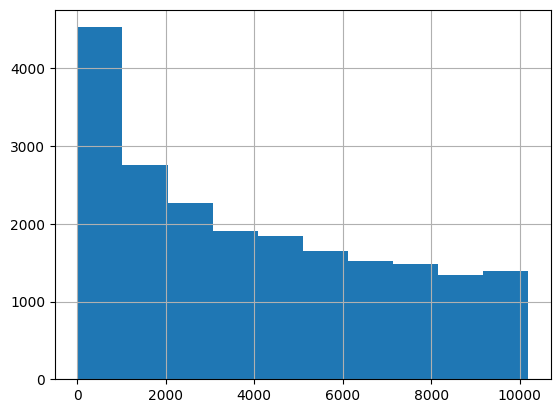

In [171]:
importer_profile['importer_rank'].hist()

In [169]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [172]:
def assign_importer_rank_category(importer_rank_list, thresholds):
    # Sort the thresholds in ascending order
    thresholds.sort()

    # Define category labels based on the number of thresholds
    categories = [f'R{i}' for i in range(1, len(thresholds) + 1)]

    # Assign categories based on the thresholds
    category_series = pd.cut(importer_rank_list, bins=[-float('inf')] + thresholds + [float('inf')], labels=categories, right=False)

    return category_series
 

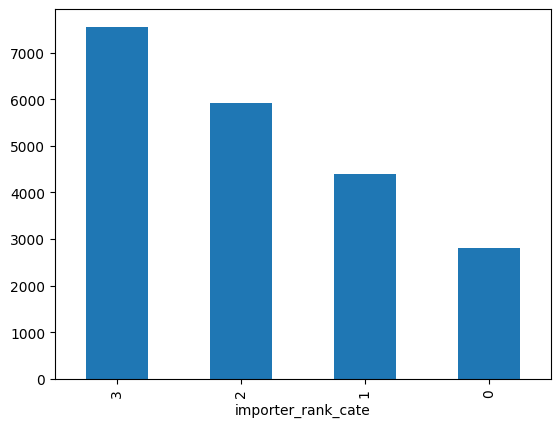

In [192]:
importer_profile['importer_rank_cate'] = importer_profile['importer_rank'].apply(lambda x : 
                                                                                0 if x < 500
                                                                                else (1 if x < 2000 
                                                                                     else (2 if x < 5000 else 3)))

importer_profile['importer_rank_cate'].value_counts().plot.bar();

In [291]:
import xgboost as xgb

# Split the data into train and validation sets
train_df, val_df = train_test_split(importer_profile.fillna(12)[numeric_cols + ['importer_rank_cate']], test_size=0.2, random_state=42)

# Define features and target for train and validation sets
X_train = train_df.drop('importer_rank_cate', axis=1)
y_train = train_df['importer_rank_cate']
X_val = val_df.drop('importer_rank_cate', axis=1)
y_val = val_df['importer_rank_cate']



# Define XGBoost parameters
params = {
    'objective': 'multi:softmax',  # For multi-class classification
    'num_class': len(importer_profile['importer_rank_cate'].unique()),  # Number of classes
    'eval_metric': 'merror',  # Evaluation metric, you can choose 'mlogloss' for log-likelihood
    'eta': 0.1,  # Learning rate
    'max_depth': 3,  # Maximum depth of a tree
    'subsample': 0.8,  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'seed': 42  # Seed for reproducibility
}

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Train the model
num_round = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_round, evals=[(dval, 'validation')])

# Predict on the validation set
y_val_pred = model.predict(dval)

# Evaluate the accuracy on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy}')


[0]	validation-merror:0.62031
[1]	validation-merror:0.62491
[2]	validation-merror:0.62225
[3]	validation-merror:0.62031
[4]	validation-merror:0.62031
[5]	validation-merror:0.61838
[6]	validation-merror:0.61693
[7]	validation-merror:0.61838
[8]	validation-merror:0.61572
[9]	validation-merror:0.61693
[10]	validation-merror:0.61741
[11]	validation-merror:0.61935
[12]	validation-merror:0.61983
[13]	validation-merror:0.62031
[14]	validation-merror:0.61862
[15]	validation-merror:0.61911
[16]	validation-merror:0.61911
[17]	validation-merror:0.62056
[18]	validation-merror:0.61959
[19]	validation-merror:0.61959
[20]	validation-merror:0.61886
[21]	validation-merror:0.61790
[22]	validation-merror:0.61862
[23]	validation-merror:0.62031
[24]	validation-merror:0.62080
[25]	validation-merror:0.62007
[26]	validation-merror:0.62080
[27]	validation-merror:0.62128
[28]	validation-merror:0.62128
[29]	validation-merror:0.62031
[30]	validation-merror:0.62177
[31]	validation-merror:0.62128
[32]	validation-me

In [292]:
from sklearn.metrics import recall_score, precision_score

In [293]:
import xgboost as xgb
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope



# Assuming your DataFrame is named 'importer_profile' with 'numeric_cols' and 'importer_rank_cate'

# Objective function to minimize (negative accuracy for maximization)
def objective(params):
    booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=100,
            evals=[(dval, 'validation')],
            early_stopping_rounds=50
        )
    
    # Predict on the validation set
    y_val_pred = model.predict(dval)

    # Calculate accuracy
    accuracy = precision_score(y_val, y_val_pred, average='micro')

    return {'loss': -accuracy, 'status': STATUS_OK}

# Define hyperparameter space for hyperopt
search_space = {
    'objective': 'multi:softmax',
    'eta': hp.uniform('eta', 0.01, 0.3),
    'learning_rate': hp.loguniform('learning_rate', -4, -1),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'num_class': 4
    }
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)


[0]	validation-mlogloss:1.38051                                                                                                                                                          
[1]	validation-mlogloss:1.37528                                                                                                                                                          
[2]	validation-mlogloss:1.36992                                                                                                                                                          
[3]	validation-mlogloss:1.36530                                                                                                                                                          
[4]	validation-mlogloss:1.36129                                                                                                                                                          
[5]	validation-mlogloss:1.35690                                       

[44]	validation-mlogloss:1.30130                                                                                                                                                         
[45]	validation-mlogloss:1.30106                                                                                                                                                         
[46]	validation-mlogloss:1.30082                                                                                                                                                         
[47]	validation-mlogloss:1.30062                                                                                                                                                         
[48]	validation-mlogloss:1.30024                                                                                                                                                         
[49]	validation-mlogloss:1.29994                                      

[88]	validation-mlogloss:1.29669                                                                                                                                                         
[89]	validation-mlogloss:1.29668                                                                                                                                                         
[90]	validation-mlogloss:1.29673                                                                                                                                                         
[91]	validation-mlogloss:1.29672                                                                                                                                                         
[92]	validation-mlogloss:1.29672                                                                                                                                                         
[93]	validation-mlogloss:1.29668                                      

[32]	validation-mlogloss:1.30039                                                                                                                                                         
[33]	validation-mlogloss:1.30020                                                                                                                                                         
[34]	validation-mlogloss:1.30027                                                                                                                                                         
[35]	validation-mlogloss:1.30019                                                                                                                                                         
[36]	validation-mlogloss:1.30015                                                                                                                                                         
[37]	validation-mlogloss:1.30038                                      

[76]	validation-mlogloss:1.30136                                                                                                                                                         
[77]	validation-mlogloss:1.30130                                                                                                                                                         
[78]	validation-mlogloss:1.30143                                                                                                                                                         
[79]	validation-mlogloss:1.30179                                                                                                                                                         
[80]	validation-mlogloss:1.30204                                                                                                                                                         
[81]	validation-mlogloss:1.30206                                      

[33]	validation-mlogloss:1.29804                                                                                                                                                         
[34]	validation-mlogloss:1.29772                                                                                                                                                         
[35]	validation-mlogloss:1.29771                                                                                                                                                         
[36]	validation-mlogloss:1.29784                                                                                                                                                         
[37]	validation-mlogloss:1.29780                                                                                                                                                         
[38]	validation-mlogloss:1.29792                                      

[77]	validation-mlogloss:1.29879                                                                                                                                                         
[78]	validation-mlogloss:1.29884                                                                                                                                                         
[79]	validation-mlogloss:1.29885                                                                                                                                                         
[80]	validation-mlogloss:1.29896                                                                                                                                                         
[81]	validation-mlogloss:1.29923                                                                                                                                                         
[82]	validation-mlogloss:1.29938                                      

[25]	validation-mlogloss:1.30247                                                                                                                                                         
[26]	validation-mlogloss:1.30233                                                                                                                                                         
[27]	validation-mlogloss:1.30249                                                                                                                                                         
[28]	validation-mlogloss:1.30259                                                                                                                                                         
[29]	validation-mlogloss:1.30234                                                                                                                                                         
[30]	validation-mlogloss:1.30269                                      

[3]	validation-mlogloss:1.34391                                                                                                                                                          
[4]	validation-mlogloss:1.33769                                                                                                                                                          
[5]	validation-mlogloss:1.33118                                                                                                                                                          
[6]	validation-mlogloss:1.32633                                                                                                                                                          
[7]	validation-mlogloss:1.32218                                                                                                                                                          
[8]	validation-mlogloss:1.31871                                       

[47]	validation-mlogloss:1.30393                                                                                                                                                         
[48]	validation-mlogloss:1.30413                                                                                                                                                         
[49]	validation-mlogloss:1.30493                                                                                                                                                         
[50]	validation-mlogloss:1.30510                                                                                                                                                         
[51]	validation-mlogloss:1.30488                                                                                                                                                         
[52]	validation-mlogloss:1.30534                                      

[14]	validation-mlogloss:1.31388                                                                                                                                                         
[15]	validation-mlogloss:1.31178                                                                                                                                                         
[16]	validation-mlogloss:1.31030                                                                                                                                                         
[17]	validation-mlogloss:1.30948                                                                                                                                                         
[18]	validation-mlogloss:1.30860                                                                                                                                                         
[19]	validation-mlogloss:1.30747                                      

[58]	validation-mlogloss:1.29878                                                                                                                                                         
[59]	validation-mlogloss:1.29885                                                                                                                                                         
[60]	validation-mlogloss:1.29907                                                                                                                                                         
[61]	validation-mlogloss:1.29911                                                                                                                                                         
[62]	validation-mlogloss:1.29926                                                                                                                                                         
[63]	validation-mlogloss:1.29918                                      

[7]	validation-mlogloss:1.33034                                                                                                                                                          
[8]	validation-mlogloss:1.32624                                                                                                                                                          
[9]	validation-mlogloss:1.32318                                                                                                                                                          
[10]	validation-mlogloss:1.32009                                                                                                                                                         
[11]	validation-mlogloss:1.31739                                                                                                                                                         
[12]	validation-mlogloss:1.31459                                      

[51]	validation-mlogloss:1.30014                                                                                                                                                         
[52]	validation-mlogloss:1.30032                                                                                                                                                         
[53]	validation-mlogloss:1.30047                                                                                                                                                         
[54]	validation-mlogloss:1.30064                                                                                                                                                         
[55]	validation-mlogloss:1.30066                                                                                                                                                         
[56]	validation-mlogloss:1.30046                                      

[4]	validation-mlogloss:1.34413                                                                                                                                                          
[5]	validation-mlogloss:1.33807                                                                                                                                                          
[6]	validation-mlogloss:1.33350                                                                                                                                                          
[7]	validation-mlogloss:1.32934                                                                                                                                                          
[8]	validation-mlogloss:1.32555                                                                                                                                                          
[9]	validation-mlogloss:1.32212                                       

[48]	validation-mlogloss:1.30096                                                                                                                                                         
[49]	validation-mlogloss:1.30093                                                                                                                                                         
[50]	validation-mlogloss:1.30102                                                                                                                                                         
[51]	validation-mlogloss:1.30099                                                                                                                                                         
[52]	validation-mlogloss:1.30140                                                                                                                                                         
[53]	validation-mlogloss:1.30172                                      

[6]	validation-mlogloss:1.30274                                                                                                                                                          
[7]	validation-mlogloss:1.30189                                                                                                                                                          
[8]	validation-mlogloss:1.30117                                                                                                                                                          
[9]	validation-mlogloss:1.30255                                                                                                                                                          
[10]	validation-mlogloss:1.30335                                                                                                                                                         
[11]	validation-mlogloss:1.30422                                      

[50]	validation-mlogloss:1.33216                                                                                                                                                         
[51]	validation-mlogloss:1.33337                                                                                                                                                         
[52]	validation-mlogloss:1.33475                                                                                                                                                         
[53]	validation-mlogloss:1.33602                                                                                                                                                         
[54]	validation-mlogloss:1.33688                                                                                                                                                         
[55]	validation-mlogloss:1.33833                                      

[35]	validation-mlogloss:1.32621                                                                                                                                                         
[36]	validation-mlogloss:1.32538                                                                                                                                                         
[37]	validation-mlogloss:1.32463                                                                                                                                                         
[38]	validation-mlogloss:1.32393                                                                                                                                                         
[39]	validation-mlogloss:1.32304                                                                                                                                                         
[40]	validation-mlogloss:1.32235                                      

[79]	validation-mlogloss:1.30620                                                                                                                                                         
[80]	validation-mlogloss:1.30598                                                                                                                                                         
[81]	validation-mlogloss:1.30577                                                                                                                                                         
[82]	validation-mlogloss:1.30561                                                                                                                                                         
[83]	validation-mlogloss:1.30549                                                                                                                                                         
[84]	validation-mlogloss:1.30524                                      

[23]	validation-mlogloss:1.30213                                                                                                                                                         
[24]	validation-mlogloss:1.30216                                                                                                                                                         
[25]	validation-mlogloss:1.30226                                                                                                                                                         
[26]	validation-mlogloss:1.30188                                                                                                                                                         
[27]	validation-mlogloss:1.30163                                                                                                                                                         
[28]	validation-mlogloss:1.30156                                      

[67]	validation-mlogloss:1.30374                                                                                                                                                         
[68]	validation-mlogloss:1.30361                                                                                                                                                         
[69]	validation-mlogloss:1.30379                                                                                                                                                         
[70]	validation-mlogloss:1.30374                                                                                                                                                         
[71]	validation-mlogloss:1.30367                                                                                                                                                         
[72]	validation-mlogloss:1.30386                                      

[25]	validation-mlogloss:1.30589                                                                                                                                                         
[26]	validation-mlogloss:1.30656                                                                                                                                                         
[27]	validation-mlogloss:1.30733                                                                                                                                                         
[28]	validation-mlogloss:1.30743                                                                                                                                                         
[29]	validation-mlogloss:1.30796                                                                                                                                                         
[30]	validation-mlogloss:1.30877                                      

[6]	validation-mlogloss:1.30804                                                                                                                                                          
[7]	validation-mlogloss:1.30538                                                                                                                                                          
[8]	validation-mlogloss:1.30284                                                                                                                                                          
[9]	validation-mlogloss:1.30118                                                                                                                                                          
[10]	validation-mlogloss:1.29998                                                                                                                                                         
[11]	validation-mlogloss:1.29840                                      

[50]	validation-mlogloss:1.30043                                                                                                                                                         
[51]	validation-mlogloss:1.30028                                                                                                                                                         
[52]	validation-mlogloss:1.30018                                                                                                                                                         
[53]	validation-mlogloss:1.30065                                                                                                                                                         
[54]	validation-mlogloss:1.30086                                                                                                                                                         
[55]	validation-mlogloss:1.30125                                      

[22]	validation-mlogloss:1.29845                                                                                                                                                         
[23]	validation-mlogloss:1.29867                                                                                                                                                         
[24]	validation-mlogloss:1.29888                                                                                                                                                         
[25]	validation-mlogloss:1.29924                                                                                                                                                         
[26]	validation-mlogloss:1.29941                                                                                                                                                         
[27]	validation-mlogloss:1.29944                                      

[1]	validation-mlogloss:1.37855                                                                                                                                                          
[2]	validation-mlogloss:1.37513                                                                                                                                                          
[3]	validation-mlogloss:1.37159                                                                                                                                                          
[4]	validation-mlogloss:1.36837                                                                                                                                                          
[5]	validation-mlogloss:1.36516                                                                                                                                                          
[6]	validation-mlogloss:1.36210                                       

[45]	validation-mlogloss:1.30911                                                                                                                                                         
[46]	validation-mlogloss:1.30881                                                                                                                                                         
[47]	validation-mlogloss:1.30839                                                                                                                                                         
[48]	validation-mlogloss:1.30779                                                                                                                                                         
[49]	validation-mlogloss:1.30734                                                                                                                                                         
[50]	validation-mlogloss:1.30704                                      

[89]	validation-mlogloss:1.30013                                                                                                                                                         
[90]	validation-mlogloss:1.30002                                                                                                                                                         
[91]	validation-mlogloss:1.29989                                                                                                                                                         
[92]	validation-mlogloss:1.29983                                                                                                                                                         
[93]	validation-mlogloss:1.29971                                                                                                                                                         
[94]	validation-mlogloss:1.29964                                      

[33]	validation-mlogloss:1.34051                                                                                                                                                         
[34]	validation-mlogloss:1.33971                                                                                                                                                         
[35]	validation-mlogloss:1.33880                                                                                                                                                         
[36]	validation-mlogloss:1.33802                                                                                                                                                         
[37]	validation-mlogloss:1.33730                                                                                                                                                         
[38]	validation-mlogloss:1.33659                                      

[77]	validation-mlogloss:1.31635                                                                                                                                                         
[78]	validation-mlogloss:1.31612                                                                                                                                                         
[79]	validation-mlogloss:1.31587                                                                                                                                                         
[80]	validation-mlogloss:1.31560                                                                                                                                                         
[81]	validation-mlogloss:1.31532                                                                                                                                                         
[82]	validation-mlogloss:1.31512                                      

[21]	validation-mlogloss:1.33297                                                                                                                                                         
[22]	validation-mlogloss:1.33175                                                                                                                                                         
[23]	validation-mlogloss:1.33028                                                                                                                                                         
[24]	validation-mlogloss:1.32907                                                                                                                                                         
[25]	validation-mlogloss:1.32788                                                                                                                                                         
[26]	validation-mlogloss:1.32663                                      

[65]	validation-mlogloss:1.30399                                                                                                                                                         
[66]	validation-mlogloss:1.30388                                                                                                                                                         
[67]	validation-mlogloss:1.30363                                                                                                                                                         
[68]	validation-mlogloss:1.30346                                                                                                                                                         
[69]	validation-mlogloss:1.30332                                                                                                                                                         
[70]	validation-mlogloss:1.30310                                      

[9]	validation-mlogloss:1.31723                                                                                                                                                          
[10]	validation-mlogloss:1.31449                                                                                                                                                         
[11]	validation-mlogloss:1.31214                                                                                                                                                         
[12]	validation-mlogloss:1.30993                                                                                                                                                         
[13]	validation-mlogloss:1.30872                                                                                                                                                         
[14]	validation-mlogloss:1.30743                                      

[53]	validation-mlogloss:1.29777                                                                                                                                                         
[54]	validation-mlogloss:1.29793                                                                                                                                                         
[55]	validation-mlogloss:1.29781                                                                                                                                                         
[56]	validation-mlogloss:1.29791                                                                                                                                                         
[57]	validation-mlogloss:1.29789                                                                                                                                                         
[58]	validation-mlogloss:1.29782                                      

[97]	validation-mlogloss:1.29948                                                                                                                                                         
[98]	validation-mlogloss:1.29967                                                                                                                                                         
[99]	validation-mlogloss:1.29979                                                                                                                                                         
[0]	validation-mlogloss:1.36636                                                                                                                                                          
[1]	validation-mlogloss:1.35175                                                                                                                                                          
[2]	validation-mlogloss:1.33968                                       

[41]	validation-mlogloss:1.29628                                                                                                                                                         
[42]	validation-mlogloss:1.29621                                                                                                                                                         
[43]	validation-mlogloss:1.29609                                                                                                                                                         
[44]	validation-mlogloss:1.29613                                                                                                                                                         
[45]	validation-mlogloss:1.29621                                                                                                                                                         
[46]	validation-mlogloss:1.29611                                      

[85]	validation-mlogloss:1.29801                                                                                                                                                         
[86]	validation-mlogloss:1.29816                                                                                                                                                         
[87]	validation-mlogloss:1.29827                                                                                                                                                         
[88]	validation-mlogloss:1.29833                                                                                                                                                         
[89]	validation-mlogloss:1.29851                                                                                                                                                         
[90]	validation-mlogloss:1.29843                                      

[32]	validation-mlogloss:1.32871                                                                                                                                                         
[33]	validation-mlogloss:1.32760                                                                                                                                                         
[34]	validation-mlogloss:1.32681                                                                                                                                                         
[35]	validation-mlogloss:1.32587                                                                                                                                                         
[36]	validation-mlogloss:1.32514                                                                                                                                                         
[37]	validation-mlogloss:1.32449                                      

[76]	validation-mlogloss:1.30817                                                                                                                                                         
[77]	validation-mlogloss:1.30795                                                                                                                                                         
[78]	validation-mlogloss:1.30780                                                                                                                                                         
[79]	validation-mlogloss:1.30774                                                                                                                                                         
[80]	validation-mlogloss:1.30764                                                                                                                                                         
[81]	validation-mlogloss:1.30751                                      

[20]	validation-mlogloss:1.31353                                                                                                                                                         
[21]	validation-mlogloss:1.31253                                                                                                                                                         
[22]	validation-mlogloss:1.31155                                                                                                                                                         
[23]	validation-mlogloss:1.31051                                                                                                                                                         
[24]	validation-mlogloss:1.30962                                                                                                                                                         
[25]	validation-mlogloss:1.30870                                      

[64]	validation-mlogloss:1.29816                                                                                                                                                         
[65]	validation-mlogloss:1.29804                                                                                                                                                         
[66]	validation-mlogloss:1.29793                                                                                                                                                         
[67]	validation-mlogloss:1.29798                                                                                                                                                         
[68]	validation-mlogloss:1.29800                                                                                                                                                         
[69]	validation-mlogloss:1.29791                                      

[8]	validation-mlogloss:1.33772                                                                                                                                                          
[9]	validation-mlogloss:1.33449                                                                                                                                                          
[10]	validation-mlogloss:1.33144                                                                                                                                                         
[11]	validation-mlogloss:1.32854                                                                                                                                                         
[12]	validation-mlogloss:1.32599                                                                                                                                                         
[13]	validation-mlogloss:1.32379                                      

[52]	validation-mlogloss:1.29793                                                                                                                                                         
[53]	validation-mlogloss:1.29780                                                                                                                                                         
[54]	validation-mlogloss:1.29768                                                                                                                                                         
[55]	validation-mlogloss:1.29765                                                                                                                                                         
[56]	validation-mlogloss:1.29750                                                                                                                                                         
[57]	validation-mlogloss:1.29751                                      

[96]	validation-mlogloss:1.29647                                                                                                                                                         
[97]	validation-mlogloss:1.29652                                                                                                                                                         
[98]	validation-mlogloss:1.29652                                                                                                                                                         
[99]	validation-mlogloss:1.29655                                                                                                                                                         
[0]	validation-mlogloss:1.38075                                                                                                                                                          
[1]	validation-mlogloss:1.37548                                       

[40]	validation-mlogloss:1.30578                                                                                                                                                         
[41]	validation-mlogloss:1.30541                                                                                                                                                         
[42]	validation-mlogloss:1.30521                                                                                                                                                         
[43]	validation-mlogloss:1.30496                                                                                                                                                         
[44]	validation-mlogloss:1.30500                                                                                                                                                         
[45]	validation-mlogloss:1.30507                                      

[84]	validation-mlogloss:1.30839                                                                                                                                                         
[85]	validation-mlogloss:1.30865                                                                                                                                                         
[86]	validation-mlogloss:1.30909                                                                                                                                                         
[87]	validation-mlogloss:1.30938                                                                                                                                                         
[88]	validation-mlogloss:1.30973                                                                                                                                                         
[89]	validation-mlogloss:1.30999                                      

[28]	validation-mlogloss:1.30474                                                                                                                                                         
[29]	validation-mlogloss:1.30414                                                                                                                                                         
[30]	validation-mlogloss:1.30392                                                                                                                                                         
[31]	validation-mlogloss:1.30329                                                                                                                                                         
[32]	validation-mlogloss:1.30291                                                                                                                                                         
[33]	validation-mlogloss:1.30245                                      

[72]	validation-mlogloss:1.29931                                                                                                                                                         
[73]	validation-mlogloss:1.29945                                                                                                                                                         
[74]	validation-mlogloss:1.29981                                                                                                                                                         
[75]	validation-mlogloss:1.29976                                                                                                                                                         
[76]	validation-mlogloss:1.29982                                                                                                                                                         
[77]	validation-mlogloss:1.29979                                      

[16]	validation-mlogloss:1.32833                                                                                                                                                         
[17]	validation-mlogloss:1.32659                                                                                                                                                         
[18]	validation-mlogloss:1.32509                                                                                                                                                         
[19]	validation-mlogloss:1.32347                                                                                                                                                         
[20]	validation-mlogloss:1.32194                                                                                                                                                         
[21]	validation-mlogloss:1.32043                                      

[60]	validation-mlogloss:1.29940                                                                                                                                                         
[61]	validation-mlogloss:1.29928                                                                                                                                                         
[62]	validation-mlogloss:1.29915                                                                                                                                                         
[63]	validation-mlogloss:1.29898                                                                                                                                                         
[64]	validation-mlogloss:1.29877                                                                                                                                                         
[65]	validation-mlogloss:1.29869                                      

[4]	validation-mlogloss:1.36063                                                                                                                                                          
[5]	validation-mlogloss:1.35644                                                                                                                                                          
[6]	validation-mlogloss:1.35309                                                                                                                                                          
[7]	validation-mlogloss:1.34956                                                                                                                                                          
[8]	validation-mlogloss:1.34610                                                                                                                                                          
[9]	validation-mlogloss:1.34279                                       

[48]	validation-mlogloss:1.30252                                                                                                                                                         
[49]	validation-mlogloss:1.30238                                                                                                                                                         
[50]	validation-mlogloss:1.30238                                                                                                                                                         
[51]	validation-mlogloss:1.30233                                                                                                                                                         
[52]	validation-mlogloss:1.30222                                                                                                                                                         
[53]	validation-mlogloss:1.30237                                      

[92]	validation-mlogloss:1.30827                                                                                                                                                         
[93]	validation-mlogloss:1.30848                                                                                                                                                         
[94]	validation-mlogloss:1.30858                                                                                                                                                         
[95]	validation-mlogloss:1.30885                                                                                                                                                         
[96]	validation-mlogloss:1.30912                                                                                                                                                         
[97]	validation-mlogloss:1.30927                                      

[36]	validation-mlogloss:1.29924                                                                                                                                                         
[37]	validation-mlogloss:1.29880                                                                                                                                                         
[38]	validation-mlogloss:1.29834                                                                                                                                                         
[39]	validation-mlogloss:1.29803                                                                                                                                                         
[40]	validation-mlogloss:1.29802                                                                                                                                                         
[41]	validation-mlogloss:1.29791                                      

[80]	validation-mlogloss:1.29713                                                                                                                                                         
[81]	validation-mlogloss:1.29710                                                                                                                                                         
[82]	validation-mlogloss:1.29709                                                                                                                                                         
[83]	validation-mlogloss:1.29725                                                                                                                                                         
[84]	validation-mlogloss:1.29747                                                                                                                                                         
[85]	validation-mlogloss:1.29734                                      

[24]	validation-mlogloss:1.34424                                                                                                                                                         
[25]	validation-mlogloss:1.34299                                                                                                                                                         
[26]	validation-mlogloss:1.34178                                                                                                                                                         
[27]	validation-mlogloss:1.34058                                                                                                                                                         
[28]	validation-mlogloss:1.33949                                                                                                                                                         
[29]	validation-mlogloss:1.33847                                      

[68]	validation-mlogloss:1.31186                                                                                                                                                         
[69]	validation-mlogloss:1.31148                                                                                                                                                         
[70]	validation-mlogloss:1.31104                                                                                                                                                         
[71]	validation-mlogloss:1.31067                                                                                                                                                         
[72]	validation-mlogloss:1.31030                                                                                                                                                         
[73]	validation-mlogloss:1.30992                                      

[12]	validation-mlogloss:1.33485                                                                                                                                                         
[13]	validation-mlogloss:1.33257                                                                                                                                                         
[14]	validation-mlogloss:1.33010                                                                                                                                                         
[15]	validation-mlogloss:1.32799                                                                                                                                                         
[16]	validation-mlogloss:1.32621                                                                                                                                                         
[17]	validation-mlogloss:1.32466                                      

[56]	validation-mlogloss:1.30186                                                                                                                                                         
[57]	validation-mlogloss:1.30184                                                                                                                                                         
[58]	validation-mlogloss:1.30163                                                                                                                                                         
[59]	validation-mlogloss:1.30163                                                                                                                                                         
[60]	validation-mlogloss:1.30156                                                                                                                                                         
[61]	validation-mlogloss:1.30143                                      

[0]	validation-mlogloss:1.37781                                                                                                                                                          
[1]	validation-mlogloss:1.37016                                                                                                                                                          
[2]	validation-mlogloss:1.36260                                                                                                                                                          
[3]	validation-mlogloss:1.35644                                                                                                                                                          
[4]	validation-mlogloss:1.35134                                                                                                                                                          
[5]	validation-mlogloss:1.34586                                       

[44]	validation-mlogloss:1.29855                                                                                                                                                         
[45]	validation-mlogloss:1.29853                                                                                                                                                         
[46]	validation-mlogloss:1.29872                                                                                                                                                         
[47]	validation-mlogloss:1.29868                                                                                                                                                         
[48]	validation-mlogloss:1.29855                                                                                                                                                         
[49]	validation-mlogloss:1.29857                                      

[88]	validation-mlogloss:1.30118                                                                                                                                                         
[89]	validation-mlogloss:1.30137                                                                                                                                                         
[90]	validation-mlogloss:1.30135                                                                                                                                                         
[91]	validation-mlogloss:1.30149                                                                                                                                                         
[92]	validation-mlogloss:1.30165                                                                                                                                                         
[93]	validation-mlogloss:1.30173                                      

[32]	validation-mlogloss:1.33622                                                                                                                                                         
[33]	validation-mlogloss:1.33526                                                                                                                                                         
[34]	validation-mlogloss:1.33429                                                                                                                                                         
[35]	validation-mlogloss:1.33338                                                                                                                                                         
[36]	validation-mlogloss:1.33248                                                                                                                                                         
[37]	validation-mlogloss:1.33156                                      

[76]	validation-mlogloss:1.30958                                                                                                                                                         
[77]	validation-mlogloss:1.30930                                                                                                                                                         
[78]	validation-mlogloss:1.30901                                                                                                                                                         
[79]	validation-mlogloss:1.30869                                                                                                                                                         
[80]	validation-mlogloss:1.30836                                                                                                                                                         
[81]	validation-mlogloss:1.30807                                      

[20]	validation-mlogloss:1.32650                                                                                                                                                         
[21]	validation-mlogloss:1.32515                                                                                                                                                         
[22]	validation-mlogloss:1.32395                                                                                                                                                         
[23]	validation-mlogloss:1.32256                                                                                                                                                         
[24]	validation-mlogloss:1.32143                                                                                                                                                         
[25]	validation-mlogloss:1.32025                                      

[64]	validation-mlogloss:1.30188                                                                                                                                                         
[65]	validation-mlogloss:1.30172                                                                                                                                                         
[66]	validation-mlogloss:1.30159                                                                                                                                                         
[67]	validation-mlogloss:1.30156                                                                                                                                                         
[68]	validation-mlogloss:1.30155                                                                                                                                                         
[69]	validation-mlogloss:1.30145                                      

[8]	validation-mlogloss:1.33185                                                                                                                                                          
[9]	validation-mlogloss:1.32852                                                                                                                                                          
[10]	validation-mlogloss:1.32562                                                                                                                                                         
[11]	validation-mlogloss:1.32268                                                                                                                                                         
[12]	validation-mlogloss:1.32010                                                                                                                                                         
[13]	validation-mlogloss:1.31790                                      

[52]	validation-mlogloss:1.29732                                                                                                                                                         
[53]	validation-mlogloss:1.29737                                                                                                                                                         
[54]	validation-mlogloss:1.29738                                                                                                                                                         
[55]	validation-mlogloss:1.29726                                                                                                                                                         
[56]	validation-mlogloss:1.29715                                                                                                                                                         
[57]	validation-mlogloss:1.29713                                      

[96]	validation-mlogloss:1.29805                                                                                                                                                         
[97]	validation-mlogloss:1.29807                                                                                                                                                         
[98]	validation-mlogloss:1.29811                                                                                                                                                         
[99]	validation-mlogloss:1.29820                                                                                                                                                         
[0]	validation-mlogloss:1.38381                                                                                                                                                          
[1]	validation-mlogloss:1.38152                                       

[40]	validation-mlogloss:1.32543                                                                                                                                                         
[41]	validation-mlogloss:1.32467                                                                                                                                                         
[42]	validation-mlogloss:1.32389                                                                                                                                                         
[43]	validation-mlogloss:1.32317                                                                                                                                                         
[44]	validation-mlogloss:1.32246                                                                                                                                                         
[45]	validation-mlogloss:1.32172                                      

[84]	validation-mlogloss:1.30504                                                                                                                                                         
[85]	validation-mlogloss:1.30478                                                                                                                                                         
[86]	validation-mlogloss:1.30462                                                                                                                                                         
[87]	validation-mlogloss:1.30442                                                                                                                                                         
[88]	validation-mlogloss:1.30421                                                                                                                                                         
[89]	validation-mlogloss:1.30403                                      

[28]	validation-mlogloss:1.32008                                                                                                                                                         
[29]	validation-mlogloss:1.31908                                                                                                                                                         
[30]	validation-mlogloss:1.31820                                                                                                                                                         
[31]	validation-mlogloss:1.31712                                                                                                                                                         
[32]	validation-mlogloss:1.31627                                                                                                                                                         
[33]	validation-mlogloss:1.31545                                      

[72]	validation-mlogloss:1.30364                                                                                                                                                         
[73]	validation-mlogloss:1.30352                                                                                                                                                         
[74]	validation-mlogloss:1.30340                                                                                                                                                         
[75]	validation-mlogloss:1.30335                                                                                                                                                         
[76]	validation-mlogloss:1.30313                                                                                                                                                         
[77]	validation-mlogloss:1.30316                                      

[16]	validation-mlogloss:1.35126                                                                                                                                                         
[17]	validation-mlogloss:1.34993                                                                                                                                                         
[18]	validation-mlogloss:1.34851                                                                                                                                                         
[19]	validation-mlogloss:1.34696                                                                                                                                                         
[20]	validation-mlogloss:1.34538                                                                                                                                                         
[21]	validation-mlogloss:1.34418                                      

[60]	validation-mlogloss:1.31362                                                                                                                                                         
[61]	validation-mlogloss:1.31312                                                                                                                                                         
[62]	validation-mlogloss:1.31274                                                                                                                                                         
[63]	validation-mlogloss:1.31244                                                                                                                                                         
[64]	validation-mlogloss:1.31215                                                                                                                                                         
[65]	validation-mlogloss:1.31174                                      

[4]	validation-mlogloss:1.36001                                                                                                                                                          
[5]	validation-mlogloss:1.35563                                                                                                                                                          
[6]	validation-mlogloss:1.35176                                                                                                                                                          
[7]	validation-mlogloss:1.34810                                                                                                                                                          
[8]	validation-mlogloss:1.34467                                                                                                                                                          
[9]	validation-mlogloss:1.34151                                       

[48]	validation-mlogloss:1.30093                                                                                                                                                         
[49]	validation-mlogloss:1.30072                                                                                                                                                         
[50]	validation-mlogloss:1.30056                                                                                                                                                         
[51]	validation-mlogloss:1.30019                                                                                                                                                         
[52]	validation-mlogloss:1.30009                                                                                                                                                         
[53]	validation-mlogloss:1.29990                                      

[92]	validation-mlogloss:1.29739                                                                                                                                                         
[93]	validation-mlogloss:1.29737                                                                                                                                                         
[94]	validation-mlogloss:1.29731                                                                                                                                                         
[95]	validation-mlogloss:1.29729                                                                                                                                                         
[96]	validation-mlogloss:1.29724                                                                                                                                                         
[97]	validation-mlogloss:1.29726                                      

[36]	validation-mlogloss:1.29700                                                                                                                                                         
[37]	validation-mlogloss:1.29717                                                                                                                                                         
[38]	validation-mlogloss:1.29707                                                                                                                                                         
[39]	validation-mlogloss:1.29713                                                                                                                                                         
[40]	validation-mlogloss:1.29740                                                                                                                                                         
[41]	validation-mlogloss:1.29732                                      

[80]	validation-mlogloss:1.30067                                                                                                                                                         
[0]	validation-mlogloss:1.37388                                                                                                                                                          
[1]	validation-mlogloss:1.36360                                                                                                                                                          
[2]	validation-mlogloss:1.35411                                                                                                                                                          
[3]	validation-mlogloss:1.34648                                                                                                                                                          
[4]	validation-mlogloss:1.33996                                       

[43]	validation-mlogloss:1.29699                                                                                                                                                         
[44]	validation-mlogloss:1.29688                                                                                                                                                         
[45]	validation-mlogloss:1.29716                                                                                                                                                         
[46]	validation-mlogloss:1.29704                                                                                                                                                         
[47]	validation-mlogloss:1.29693                                                                                                                                                         
[48]	validation-mlogloss:1.29709                                      

[87]	validation-mlogloss:1.29952                                                                                                                                                         
[88]	validation-mlogloss:1.29952                                                                                                                                                         
[89]	validation-mlogloss:1.29954                                                                                                                                                         
[90]	validation-mlogloss:1.29942                                                                                                                                                         
[91]	validation-mlogloss:1.29949                                                                                                                                                         
[92]	validation-mlogloss:1.29967                                      

[31]	validation-mlogloss:1.30034                                                                                                                                                         
[32]	validation-mlogloss:1.30014                                                                                                                                                         
[33]	validation-mlogloss:1.29986                                                                                                                                                         
[34]	validation-mlogloss:1.29966                                                                                                                                                         
[35]	validation-mlogloss:1.29936                                                                                                                                                         
[36]	validation-mlogloss:1.29917                                      

[75]	validation-mlogloss:1.29639                                                                                                                                                         
[76]	validation-mlogloss:1.29640                                                                                                                                                         
[77]	validation-mlogloss:1.29649                                                                                                                                                         
[78]	validation-mlogloss:1.29653                                                                                                                                                         
[79]	validation-mlogloss:1.29664                                                                                                                                                         
[80]	validation-mlogloss:1.29662                                      

[19]	validation-mlogloss:1.33414                                                                                                                                                         
[20]	validation-mlogloss:1.33245                                                                                                                                                         
[21]	validation-mlogloss:1.33107                                                                                                                                                         
[22]	validation-mlogloss:1.32982                                                                                                                                                         
[23]	validation-mlogloss:1.32830                                                                                                                                                         
[24]	validation-mlogloss:1.32708                                      

[63]	validation-mlogloss:1.30232                                                                                                                                                         
[64]	validation-mlogloss:1.30207                                                                                                                                                         
[65]	validation-mlogloss:1.30186                                                                                                                                                         
[66]	validation-mlogloss:1.30167                                                                                                                                                         
[67]	validation-mlogloss:1.30153                                                                                                                                                         
[68]	validation-mlogloss:1.30142                                      

[7]	validation-mlogloss:1.34834                                                                                                                                                          
[8]	validation-mlogloss:1.34491                                                                                                                                                          
[9]	validation-mlogloss:1.34179                                                                                                                                                          
[10]	validation-mlogloss:1.33892                                                                                                                                                         
[11]	validation-mlogloss:1.33592                                                                                                                                                         
[12]	validation-mlogloss:1.33321                                      

[51]	validation-mlogloss:1.30313                                                                                                                                                         
[52]	validation-mlogloss:1.30323                                                                                                                                                         
[53]	validation-mlogloss:1.30314                                                                                                                                                         
[54]	validation-mlogloss:1.30309                                                                                                                                                         
[55]	validation-mlogloss:1.30287                                                                                                                                                         
[56]	validation-mlogloss:1.30268                                      

[95]	validation-mlogloss:1.30504                                                                                                                                                         
[96]	validation-mlogloss:1.30516                                                                                                                                                         
[97]	validation-mlogloss:1.30512                                                                                                                                                         
[98]	validation-mlogloss:1.30521                                                                                                                                                         
[99]	validation-mlogloss:1.30535                                                                                                                                                         
[0]	validation-mlogloss:1.37580                                       

[39]	validation-mlogloss:1.29727                                                                                                                                                         
[40]	validation-mlogloss:1.29736                                                                                                                                                         
[41]	validation-mlogloss:1.29746                                                                                                                                                         
[42]	validation-mlogloss:1.29764                                                                                                                                                         
[43]	validation-mlogloss:1.29766                                                                                                                                                         
[44]	validation-mlogloss:1.29750                                      

[83]	validation-mlogloss:1.30165                                                                                                                                                         
[84]	validation-mlogloss:1.30201                                                                                                                                                         
[85]	validation-mlogloss:1.30195                                                                                                                                                         
[86]	validation-mlogloss:1.30215                                                                                                                                                         
[87]	validation-mlogloss:1.30254                                                                                                                                                         
[0]	validation-mlogloss:1.38302                                       

[39]	validation-mlogloss:1.31813                                                                                                                                                         
[40]	validation-mlogloss:1.31739                                                                                                                                                         
[41]	validation-mlogloss:1.31658                                                                                                                                                         
[42]	validation-mlogloss:1.31590                                                                                                                                                         
[43]	validation-mlogloss:1.31532                                                                                                                                                         
[44]	validation-mlogloss:1.31475                                      

[83]	validation-mlogloss:1.30211                                                                                                                                                         
[84]	validation-mlogloss:1.30187                                                                                                                                                         
[85]	validation-mlogloss:1.30167                                                                                                                                                         
[86]	validation-mlogloss:1.30153                                                                                                                                                         
[87]	validation-mlogloss:1.30128                                                                                                                                                         
[88]	validation-mlogloss:1.30113                                      

[27]	validation-mlogloss:1.31519                                                                                                                                                         
[28]	validation-mlogloss:1.31426                                                                                                                                                         
[29]	validation-mlogloss:1.31341                                                                                                                                                         
[30]	validation-mlogloss:1.31257                                                                                                                                                         
[31]	validation-mlogloss:1.31165                                                                                                                                                         
[32]	validation-mlogloss:1.31088                                      

[71]	validation-mlogloss:1.29766                                                                                                                                                         
[72]	validation-mlogloss:1.29757                                                                                                                                                         
[73]	validation-mlogloss:1.29744                                                                                                                                                         
[74]	validation-mlogloss:1.29749                                                                                                                                                         
[75]	validation-mlogloss:1.29744                                                                                                                                                         
[76]	validation-mlogloss:1.29728                                      

[15]	validation-mlogloss:1.30169                                                                                                                                                         
[16]	validation-mlogloss:1.30110                                                                                                                                                         
[17]	validation-mlogloss:1.30081                                                                                                                                                         
[18]	validation-mlogloss:1.30038                                                                                                                                                         
[19]	validation-mlogloss:1.29999                                                                                                                                                         
[20]	validation-mlogloss:1.29955                                      

[59]	validation-mlogloss:1.29918                                                                                                                                                         
[60]	validation-mlogloss:1.29932                                                                                                                                                         
[61]	validation-mlogloss:1.29935                                                                                                                                                         
[62]	validation-mlogloss:1.29941                                                                                                                                                         
[63]	validation-mlogloss:1.29939                                                                                                                                                         
[64]	validation-mlogloss:1.29946                                      

[24]	validation-mlogloss:1.31058                                                                                                                                                         
[25]	validation-mlogloss:1.30963                                                                                                                                                         
[26]	validation-mlogloss:1.30895                                                                                                                                                         
[27]	validation-mlogloss:1.30791                                                                                                                                                         
[28]	validation-mlogloss:1.30713                                                                                                                                                         
[29]	validation-mlogloss:1.30649                                      

[68]	validation-mlogloss:1.30555                                                                                                                                                         
[69]	validation-mlogloss:1.30590                                                                                                                                                         
[70]	validation-mlogloss:1.30629                                                                                                                                                         
[71]	validation-mlogloss:1.30654                                                                                                                                                         
[72]	validation-mlogloss:1.30690                                                                                                                                                         
[73]	validation-mlogloss:1.30711                                      

[18]	validation-mlogloss:1.31329                                                                                                                                                         
[19]	validation-mlogloss:1.31456                                                                                                                                                         
[20]	validation-mlogloss:1.31518                                                                                                                                                         
[21]	validation-mlogloss:1.31701                                                                                                                                                         
[22]	validation-mlogloss:1.31806                                                                                                                                                         
[23]	validation-mlogloss:1.31921                                      

[1]	validation-mlogloss:1.36562                                                                                                                                                          
[2]	validation-mlogloss:1.35602                                                                                                                                                          
[3]	validation-mlogloss:1.34848                                                                                                                                                          
[4]	validation-mlogloss:1.34253                                                                                                                                                          
[5]	validation-mlogloss:1.33621                                                                                                                                                          
[6]	validation-mlogloss:1.33156                                       

[45]	validation-mlogloss:1.30040                                                                                                                                                         
[46]	validation-mlogloss:1.30052                                                                                                                                                         
[47]	validation-mlogloss:1.30076                                                                                                                                                         
[48]	validation-mlogloss:1.30067                                                                                                                                                         
[49]	validation-mlogloss:1.30085                                                                                                                                                         
[50]	validation-mlogloss:1.30087                                      

[2]	validation-mlogloss:1.34074                                                                                                                                                          
[3]	validation-mlogloss:1.33181                                                                                                                                                          
[4]	validation-mlogloss:1.32484                                                                                                                                                          
[5]	validation-mlogloss:1.31843                                                                                                                                                          
[6]	validation-mlogloss:1.31419                                                                                                                                                          
[7]	validation-mlogloss:1.31075                                       

[46]	validation-mlogloss:1.30258                                                                                                                                                         
[47]	validation-mlogloss:1.30303                                                                                                                                                         
[48]	validation-mlogloss:1.30283                                                                                                                                                         
[49]	validation-mlogloss:1.30314                                                                                                                                                         
[50]	validation-mlogloss:1.30308                                                                                                                                                         
[51]	validation-mlogloss:1.30326                                      

In [294]:
best_result

{'colsample_bytree': 0.8547296491853194,
 'eta': 0.055691158441579375,
 'learning_rate': 0.05332788289181764,
 'max_depth': 4.0,
 'min_child_weight': 0.7975381135154598,
 'subsample': 0.6261590306196418}

In [295]:
# Retrieve the best hyperparameters from the Trials object
best_params = hyperopt.space_eval(search_space, best_result)

In [302]:
# Train the final model with the best hyperparameters
best_model = xgb.train(
    params=best_params,
    dtrain=dtrain, 
    num_boost_round=100,
    evals=[(dval, 'validation')])

# Predict on the validation set with the best model
y_val_pred_best = best_model.predict(dval)

# Evaluate the accuracy on the validation set with the best model
accuracy_best = accuracy_score(y_val, y_val_pred_best)
print(f'Validation Accuracy with Best Hyperparameters: {accuracy_best}')


[0]	validation-mlogloss:1.38051
[1]	validation-mlogloss:1.37528
[2]	validation-mlogloss:1.36992
[3]	validation-mlogloss:1.36530
[4]	validation-mlogloss:1.36129
[5]	validation-mlogloss:1.35690
[6]	validation-mlogloss:1.35327
[7]	validation-mlogloss:1.34968
[8]	validation-mlogloss:1.34630
[9]	validation-mlogloss:1.34325
[10]	validation-mlogloss:1.34036
[11]	validation-mlogloss:1.33739
[12]	validation-mlogloss:1.33471
[13]	validation-mlogloss:1.33241
[14]	validation-mlogloss:1.33005
[15]	validation-mlogloss:1.32782
[16]	validation-mlogloss:1.32592
[17]	validation-mlogloss:1.32429
[18]	validation-mlogloss:1.32265
[19]	validation-mlogloss:1.32098
[20]	validation-mlogloss:1.31925
[21]	validation-mlogloss:1.31802
[22]	validation-mlogloss:1.31674
[23]	validation-mlogloss:1.31544
[24]	validation-mlogloss:1.31436
[25]	validation-mlogloss:1.31318
[26]	validation-mlogloss:1.31205
[27]	validation-mlogloss:1.31103
[28]	validation-mlogloss:1.31003
[29]	validation-mlogloss:1.30921
[30]	validation-mlog

In [303]:
from sklearn.metrics import classification_report, confusion_matrix 


In [304]:

# Convert predicted probabilities to class labels
y_val_pred = y_val_pred_best.astype(int)

# Generate the classification report
report = classification_report(y_val, y_val_pred)

In [305]:
print(report)

              precision    recall  f1-score   support

           0       0.46      0.07      0.13       554
           1       0.30      0.08      0.13       886
           2       0.31      0.11      0.16      1199
           3       0.39      0.90      0.55      1496

    accuracy                           0.38      4135
   macro avg       0.37      0.29      0.24      4135
weighted avg       0.36      0.38      0.29      4135



    y_va

In [340]:
from sklearn.ensemble import GradientBoostingClassifier


# Separate features and target variable
X = importer_profile.fillna(12)[numeric_cols+categorical_cols]
y = importer_profile['importer_rank_cate']

# One-hot encode the categorical column
X_encoded = pd.get_dummies(X, columns=categorical_cols)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    
clf = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,
    max_depth=2, random_state=0).fit(X_train, y_train)


In [343]:
y_val_pred = clf.predict(X_val).astype(int)
report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.48      0.18      0.26       554
           1       0.37      0.15      0.22       886
           2       0.35      0.19      0.25      1199
           3       0.42      0.81      0.55      1496

    accuracy                           0.41      4135
   macro avg       0.41      0.33      0.32      4135
weighted avg       0.40      0.41      0.35      4135



In [344]:
# Assuming gb_classifier is already trained

# Display feature importances
feature_importances = clf.feature_importances_
feature_names = X_encoded.columns

# Create a DataFrame to display the results
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 20 important features
top_20_features = feature_importance_df.head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance')
plt.show()


In [348]:
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Assuming your DataFrame is named 'importer_profile' with 'numeric_cols' and 'categorical_cols'

# Separate features and target variable
X = importer_profile.fillna(12)[numeric_cols + categorical_cols]
y = importer_profile['importer_rank_cate']

# One-hot encode the categorical column
X_encoded = pd.get_dummies(X, columns=categorical_cols)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

search_space = {
    'learning_rate': hp.loguniform('learning_rate', -3, -1),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 2, 1)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 50, 1)),
    }


# Objective function to minimize (negative accuracy for maximization)
def objective(params):
   # Initialize and train the Gradient Boosting classifier
    clf = GradientBoostingClassifier(**params, random_state=0)
    clf.fit(X_train, y_train)

    # Predict on the validation set
    y_val_pred = clf.predict(X_val)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_val_pred)

    return {'loss': 1 - accuracy, 'status': STATUS_OK}

# Set up Trials object to keep track of results
trials = Trials()

# Use fmin to find the best hyperparameters
best = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best hyperparameters
print("Best Hyperparameters:", best)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [50:07<00:00, 60.15s/trial, best loss: 0.5869407496977026]
Best Hyperparameters: {'learning_rate': 0.343987882893179, 'max_depth': 2.0, 'n_estimators': 50.0, 'subsample': 0.711951551520743}


In [ ]:
# Retrieve the best hyperparameters from the Trials object
best_params = hyperopt.space_eval(search_space, best)

# Train the final model with the best hyperparameters
best_model = GradientBoostingClassifier(random_state=0, **best_params)
best_model.fit(X_train, y_train)

# Predict on the validation set with the best model
y_val_pred_best = best_model.predict(X_val)

# Evaluate the accuracy on the validation set with the best model
accuracy_best = accuracy_score(y_val, y_val_pred_best)
print(f'Validation Accuracy with Best Hyperparameters: {accuracy_best}')


In [ ]:
y_val_pred = best_model.predict(X_val).astype(int)
report = classification_report(y_val, y_val_pred)
print(report)